# Estudio de los datos de Ventas de una Ferretería

Autor: Diana Chacón Ocariz

## Contexto:

Se trata de una pequeña ferretería que maneja un poco más de 3.000 productos distintos. Poseen un software de gestión genérico que les provee una gran cantidad de reportes, básicamente tablas con números, díficiles de analizar (un reporte puede constar de varias decenas de páginas).


## Objetivos del negocio:

**Tener más visibilidad sobre las ventas para poder mejorar el proceso de compras y la toma de decisiones en general:** 

    - Poder analizar objetivamente las ventas
    - Determinar los productos que podrían entrar en rotura de stock al final de un período
    - Identificar los productos menos vendidos
    - Identificar patrones en el comportamiento de las ventas para poder hacer predicciones de ventas
    

## Objetivos académicos:

    - Estudiar un caso real, con datos reales y cuyo resultado pueda ayudar a alguien a resolver un problema 
    - Demostrar que la ciencia de datos también puede ayudar a las PYMES
    - Conocer y practicar el uso de herramientas de ciencia de datos
    
## Fuentes de datos:

Los datos provienen de reportes sacados del software de gestión de la empresa. Se trata de archivos .xls que contienen sólo los datos de reportes sobre ventas por producto (2021 y 2022) y el stock al final del período. También se utiliza el histórico de la tasa de cambio del dólar para hacer el análisis en base a montos en esta moneda y paliar los problemas de inflación.

# Notebook 2: EDA

Recuperamos los datos (ya limpios) de los archivos **parquet** para comenzar un análisis más profundo de los datos, responder preguntas del negocio, verificar si hay patrones en las ventas y preparar los datos para utilizarlos en modelos predictivos

In [1]:
# Librerías utilizadas

import os
import glob
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import altair as alt

In [2]:
BASE_DIR = Path.cwd()
BASE_DIR

PosixPath('/home/diana/Documentos/Ciencia de Datos/Proyecto Ventas')

In [3]:
%%time 
df_ventas = pd.read_parquet(f"{BASE_DIR / 'datos/out/ventas.parquet'}", engine='fastparquet')
df_ventas

CPU times: user 3.77 s, sys: 25.5 ms, total: 3.8 s
Wall time: 3.84 s


num          fecha_comp     cliente  vendedor    cod  \
0      0000000702 2021-01-21 10:02:00    18637949        14  00001   
1      0000000703 2021-01-21 10:24:00    19339285         7  00001   
2      0000000701 2021-01-21 09:56:00    13175393        13  00010   
3      0000000706 2021-01-21 10:37:00     5852700         7  00018   
4      0000000689 2021-01-21 09:30:00    17220345         7  00028   
...           ...                 ...         ...       ...    ...   
28920  0000006814 2022-01-20 15:06:00  14281231.0         3  06108   
28921  0000006827 2022-01-20 16:29:00   9204926.0        13  06196   
28922  0000006820 2022-01-20 15:45:00  14583939.0        14  06300   
28923  0000006787 2022-01-20 09:58:00  10749538.0        13  06306   
28924  0000006783 2022-01-20 09:03:00  24154813.0         7  06352   

                                                producto  cantidad   monto  \
0        PEGA DE CONTACTO/PEGA ZAPATERA (90 ML) ENVASADO       2.0    5.40   
1        PEGA DE CONTACTO/PEGA ZAPATERA (90 ML) ENVASADO       1.0    2.70   
2      LLAVE 1/2" ESFERICA BRONCE PALANCA GRINACA COL...       1.0    9.52   
3                                           LAPICERO BIC       1.0    0.47   
4        TEFLON PROF 1/2 * 10mts SUPER EXTRA LUZ/P.T.F.E       1.0    0.65   
...                                                  ...       ...     ...   
28920  TOMA DOBLE POLARIZADO MARFIL 15A 125V VERT JEH...       1.0    7.28   
28921                  ABRAZADERA METALICA 3/8" 6MM-13MM       3.0   13.08   
28922  CURVA 3/4" NEGRA POLIETILENO ELECTRICIDAD ECON...       2.0    1.46   
28923  REGADOR 1/2" MINI WLOBBER MINI BAILARINA DIAME...       1.0    8.05   
28924            RIEGO ABRAZADERA METALICA 200MM"* 1" JC       1.0  147.00   

      tipo      fecha  tasa_dolar  monto_dolar  
0       fa 2021-01-21    1.787455     3.021055  
1       fa 2021-01-21    1.787455     1.510527  
2       fa 2021-01-21    1.787455     5.326008  
3       fa 2021-01-21    1.787455     0.262944  
4       fa 2021-01-21    1.787455     0.363645  
...    ...        ...         ...          ...  
28920   ne 2022-01-20    4.810000     1.513514  
28921   ne 2022-01-20    4.810000     2.719335  
28922   ne 2022-01-20    4.810000     0.303534  
28923   ne 2022-01-20    4.810000     1.673597  
28924   ne 2022-01-20    4.810000    30.561331  

[28925 rows x 12 columns]

# Análisis del DF de ventas

In [4]:
df_ventas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28925 entries, 0 to 28924
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   num          28925 non-null  object        
 1   fecha_comp   28925 non-null  datetime64[ns]
 2   cliente      28925 non-null  object        
 3   vendedor     28925 non-null  int64         
 4   cod          28925 non-null  object        
 5   producto     28925 non-null  object        
 6   cantidad     28925 non-null  float64       
 7   monto        28925 non-null  float64       
 8   tipo         28925 non-null  object        
 9   fecha        28925 non-null  datetime64[ns]
 10  tasa_dolar   28925 non-null  float64       
 11  monto_dolar  28925 non-null  float64       
dtypes: datetime64[ns](2), float64(4), int64(1), object(5)
memory usage: 2.9+ MB


## Metadatos

Cada fila del DF corresponde a un producto dentro de una factura (línea de factura):

    - num: Número o referencia de la factura          
    - fecha_comp: Fecha de la factura, en formato datetime
    - cliente: Código del cliente           
    - vendedor: Código del vendedor           
    - cod: Código del producto              
    - producto: Descripción del producto          
    - cantidad: Cantidad de producto dentro de la factura   
    - monto: Monto en Bs (moneda venezolana) del producto
    - tipo: Tipo de la factura              
    - fecha: Fecha de la factura en formato yyyy-mm-dd       
    - tasa_dolar: Tasa de cambio del día        
    - monto_dolar: Monto en USD del producto

Los datos ya han sido limpiados y no hay valores nulos. 

### ¿Qué nos interesa de los datos?

3 variables nos interesan:
 - **cantidad:** Nos da el volumen de ventas (cantidad de productos vendidos).
 - **monto_dolar:** Nos da las ventas en USD.
 - **num:** Nos permite contar la cantidad de ventas o facturas. Puede dar una idea del tráfico de clientes o cuántos clientesha atendido un vendedor dado.
 
Estudiaremos el comportamiento de esas 3 variables en el tiempo.

También analizaremos: 

- Los productos: Productos más vendidos, menos vendidos, promedio de ventas, productos que se venden en grandes cantidades...
- Los vendedores: Ventas por vendedor
- Los clientes: Mejores clientes

In [5]:
df_ventas.describe()

vendedor      cantidad         monto    tasa_dolar   monto_dolar
count  28925.000000  28925.000000  28925.000000  28925.000000  28925.000000
mean       9.312083      4.566491     26.880727      3.446773      7.518570
std        3.516934     21.901486    113.978329      1.174710     29.215224
min        1.000000      0.020000      0.010000      0.795204      0.002385
25%        7.000000      1.000000      2.690000      2.127627      0.910529
50%       10.000000      1.000000      7.650000      3.946754      2.428295
75%       11.000000      3.000000     21.000000      4.540000      6.036217
max       14.000000   2000.000000   6133.500000      5.404052   1919.167521

In [6]:
df_cantidad = pd.DataFrame(df_ventas.cantidad.value_counts())

df_cantidad.reset_index(inplace=True)
df_cantidad.columns = ['cant_venta', 'cantidad']
df_cantidad.describe()

cant_venta      cantidad
count   237.000000    237.000000
mean     64.121519    122.046414
std     179.298560   1105.150401
min       0.020000      1.000000
25%       1.150000      1.000000
50%       7.400000      2.000000
75%      57.000000      5.000000
max    2000.000000  16346.000000

<AxesSubplot:xlabel='cant_venta', ylabel='Density'>

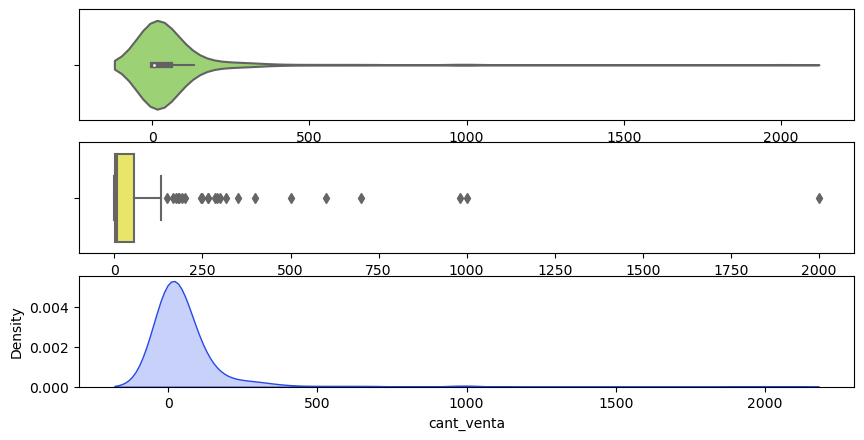

In [7]:
# Definición de los colores para los gráficos
VERDE = '#99e265' #'#5ebc0d'
AZUL = '#2649e8'  #'#17407b'
AMARILLO = '#fff952' #'#efea46'


fig, (ax1, ax2, ax3) = plt.subplots(3, 1, dpi=100, figsize=(10,5))

sns.violinplot(x='cant_venta', data=df_cantidad, color=VERDE, ax=ax1)
sns.boxplot(x='cant_venta', data=df_cantidad, color=AMARILLO, ax=ax2)
sns.kdeplot(x='cant_venta', data=df_cantidad, color=AZUL, shade=True, ax=ax3)

In [8]:
df_cantidad_min = pd.DataFrame(df_ventas.query('cantidad <= 20').cantidad.value_counts())

df_cantidad_min.reset_index(inplace=True)
df_cantidad_min.columns = ['cant_venta', 'cantidad']
df_cantidad_min.describe()

cant_venta      cantidad
count  140.000000    140.000000
mean     3.430714    199.792857
std      4.366039   1434.717095
min      0.020000      1.000000
25%      0.522500      1.000000
50%      1.480000      2.000000
75%      4.225000      4.000000
max     20.000000  16346.000000

<AxesSubplot:xlabel='cant_venta', ylabel='Density'>

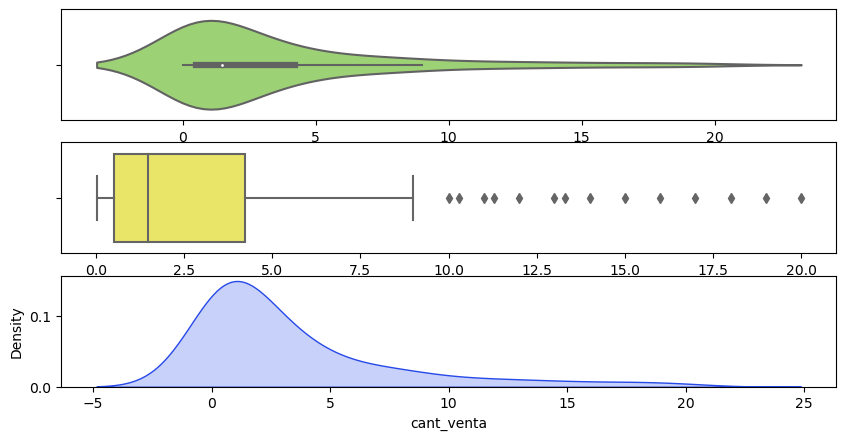

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, dpi=100, figsize=(10,5))

sns.violinplot(x='cant_venta', data=df_cantidad_min, color=VERDE, ax=ax1)
sns.boxplot(x='cant_venta', data=df_cantidad_min, color=AMARILLO, ax=ax2)
sns.kdeplot(x='cant_venta', data=df_cantidad_min, color=AZUL, shade=True, ax=ax3)


In [10]:
df_cantidad_max = pd.DataFrame(df_ventas.query('cantidad > 20').cantidad.value_counts())

df_cantidad_max.reset_index(inplace=True)
df_cantidad_max.columns = ['cant_venta', 'cantidad']
df_cantidad_max.describe()

cant_venta    cantidad
count    97.000000   97.000000
mean    151.716495    9.835052
std     256.667961   23.568464
min      21.000000    1.000000
25%      44.000000    1.000000
50%      74.000000    2.000000
75%     130.000000    6.000000
max    2000.000000  178.000000

<AxesSubplot:xlabel='cant_venta', ylabel='Density'>

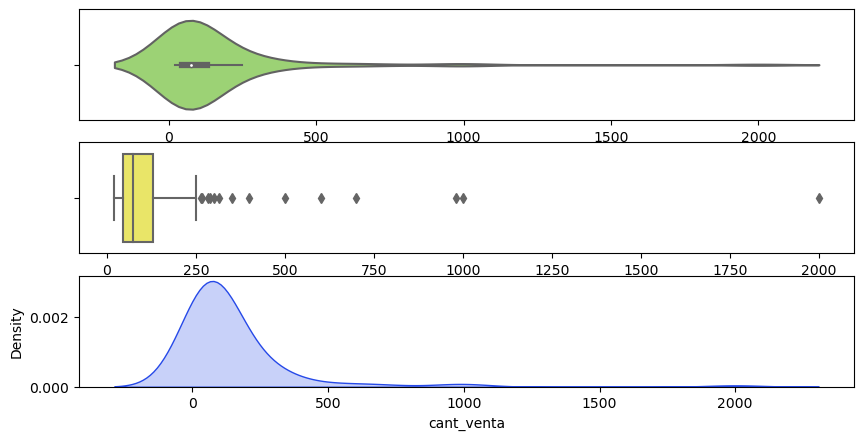

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, dpi=100, figsize=(10,5))

sns.violinplot(x='cant_venta', data=df_cantidad_max, color=VERDE, ax=ax1)
sns.boxplot(x='cant_venta', data=df_cantidad_max, color=AMARILLO, ax=ax2)
sns.kdeplot(x='cant_venta', data=df_cantidad_max, color=AZUL, shade=True, ax=ax3)

In [12]:
df_cantidad_mmax = pd.DataFrame(df_ventas.query('cantidad > 500').cantidad.value_counts())

df_cantidad_mmax.reset_index(inplace=True)
df_cantidad_mmax.columns = ['cant_venta', 'cantidad']
df_cantidad_mmax.describe()

cant_venta  cantidad
count     5.000000  5.000000
mean   1056.000000  1.600000
std     555.589777  0.547723
min     600.000000  1.000000
25%     700.000000  1.000000
50%     980.000000  2.000000
75%    1000.000000  2.000000
max    2000.000000  2.000000

<AxesSubplot:xlabel='cant_venta', ylabel='Density'>

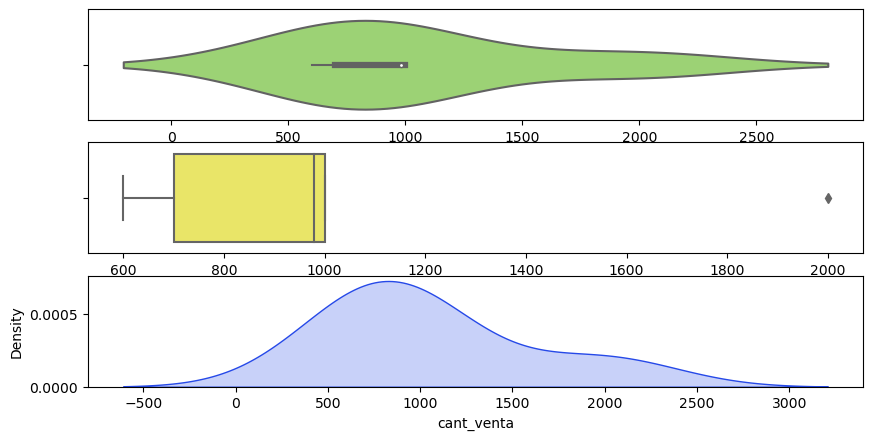

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, dpi=100, figsize=(10,5))

sns.violinplot(x='cant_venta', data=df_cantidad_mmax, color=VERDE, ax=ax1)
sns.boxplot(x='cant_venta', data=df_cantidad_mmax, color=AMARILLO, ax=ax2)
sns.kdeplot(x='cant_venta', data=df_cantidad_mmax, color=AZUL, shade=True, ax=ax3)

In [14]:
df_cantidad_moy = pd.DataFrame(df_ventas.groupby('cod').cantidad.sum()/13)

df_cantidad_moy.reset_index(inplace=True)
df_cantidad_moy.columns = ['cod', 'media_venta']
df_cantidad_moy = df_cantidad_moy.query(' media_venta > 20').sort_values('media_venta', ascending=False)
df_cantidad_moy

cod  media_venta
149   00233   909.307692
1083  02281   257.538462
794   01228   231.461538
295   00432   199.846154
134   00212   189.076923
...     ...          ...
1817  04586    21.230769
2157  05339    20.846154
1034  01841    20.615385
1162  02899    20.307692
1693  04378    20.230769

[88 rows x 2 columns]

<AxesSubplot:xlabel='media_venta', ylabel='cod'>

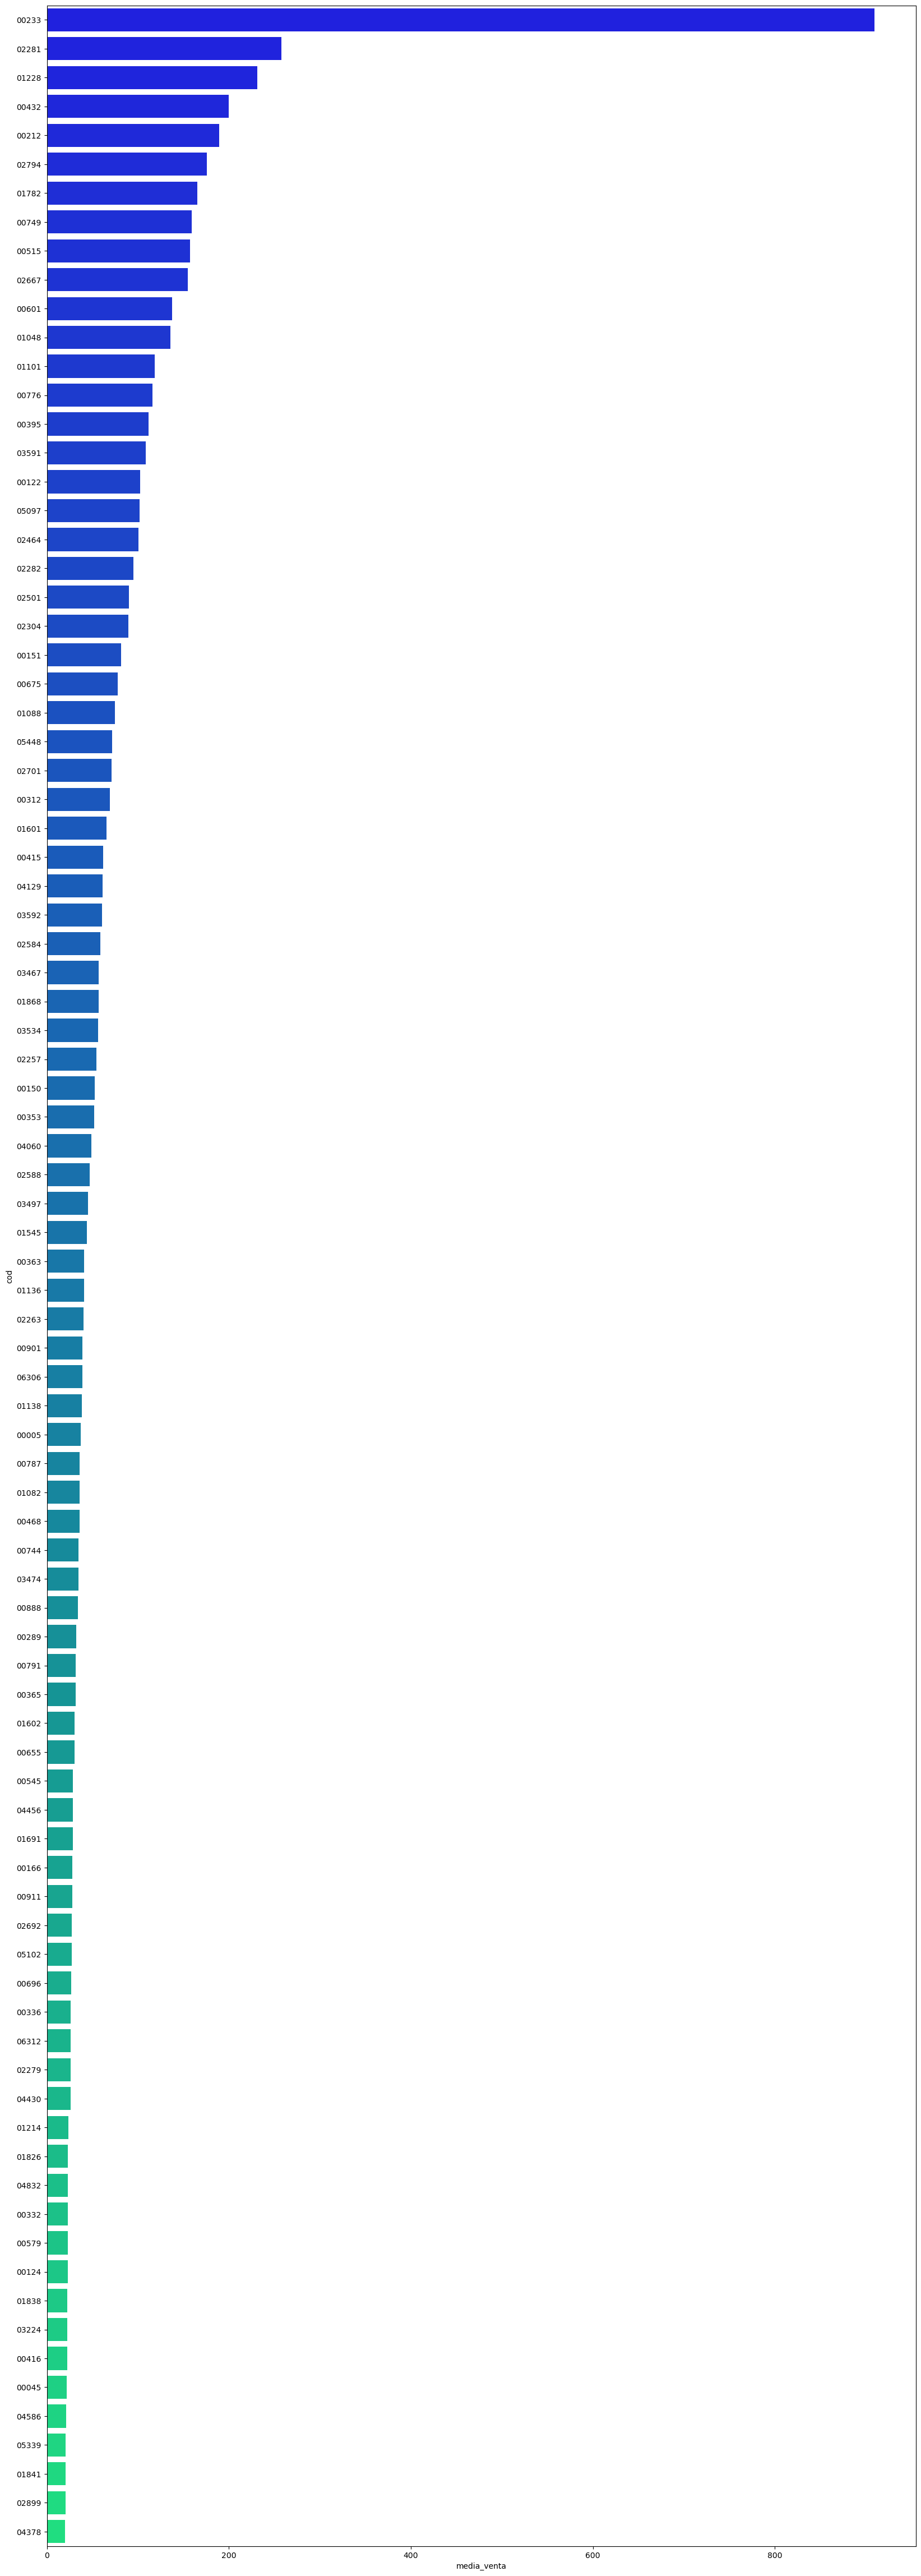

In [15]:
fig, ax = plt.subplots(1, 1, dpi=100, figsize=(20,60))

#sns.violinplot(x='cod', y='media_venta', data=df_cantidad_moy, color=VERDE, ax=ax1)
#sns.boxplot(x='cod', y='media_venta', data=df_cantidad_moy, color=AMARILLO, ax=ax2)
sns.barplot(y='cod', x='media_venta', data=df_cantidad_moy, palette='winter', ax=ax)


# Variación de las Ventas en el tiempo

In [17]:
df_ventas_fecha = df_ventas.loc[:,['fecha_comp', 'num', 'cantidad', 'monto_dolar', 'fecha']]
df_ventas_fecha.set_index('fecha_comp', inplace=True)
df_ventas_fecha

num  cantidad  monto_dolar      fecha
fecha_comp                                                       
2021-01-21 10:02:00  0000000702       2.0     3.021055 2021-01-21
2021-01-21 10:24:00  0000000703       1.0     1.510527 2021-01-21
2021-01-21 09:56:00  0000000701       1.0     5.326008 2021-01-21
2021-01-21 10:37:00  0000000706       1.0     0.262944 2021-01-21
2021-01-21 09:30:00  0000000689       1.0     0.363645 2021-01-21
...                         ...       ...          ...        ...
2022-01-20 15:06:00  0000006814       1.0     1.513514 2022-01-20
2022-01-20 16:29:00  0000006827       3.0     2.719335 2022-01-20
2022-01-20 15:45:00  0000006820       2.0     0.303534 2022-01-20
2022-01-20 09:58:00  0000006787       1.0     1.673597 2022-01-20
2022-01-20 09:03:00  0000006783       1.0    30.561331 2022-01-20

[28925 rows x 4 columns]

<AxesSubplot:xlabel='fecha_comp'>

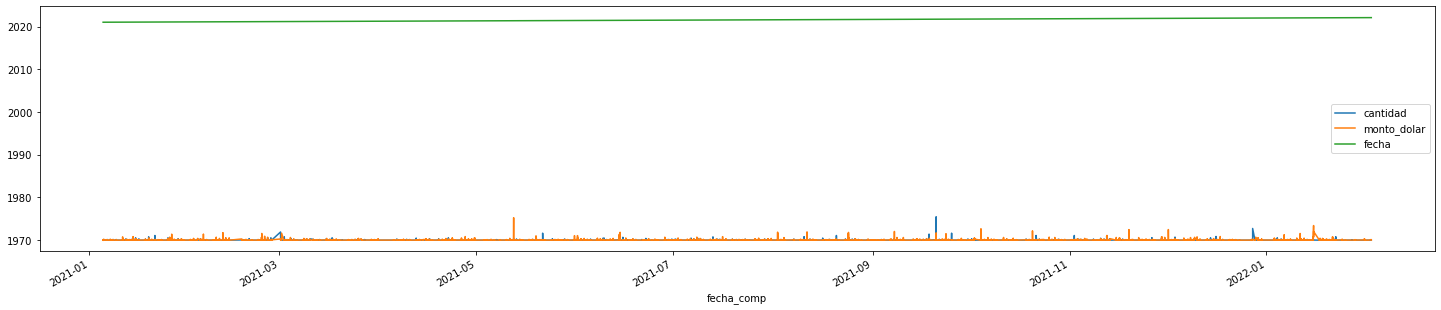

In [18]:
fix, ax = plt.subplots(figsize=(25, 5))

df_ventas_fecha.plot(ax=ax)

<AxesSubplot:xlabel='fecha_comp'>

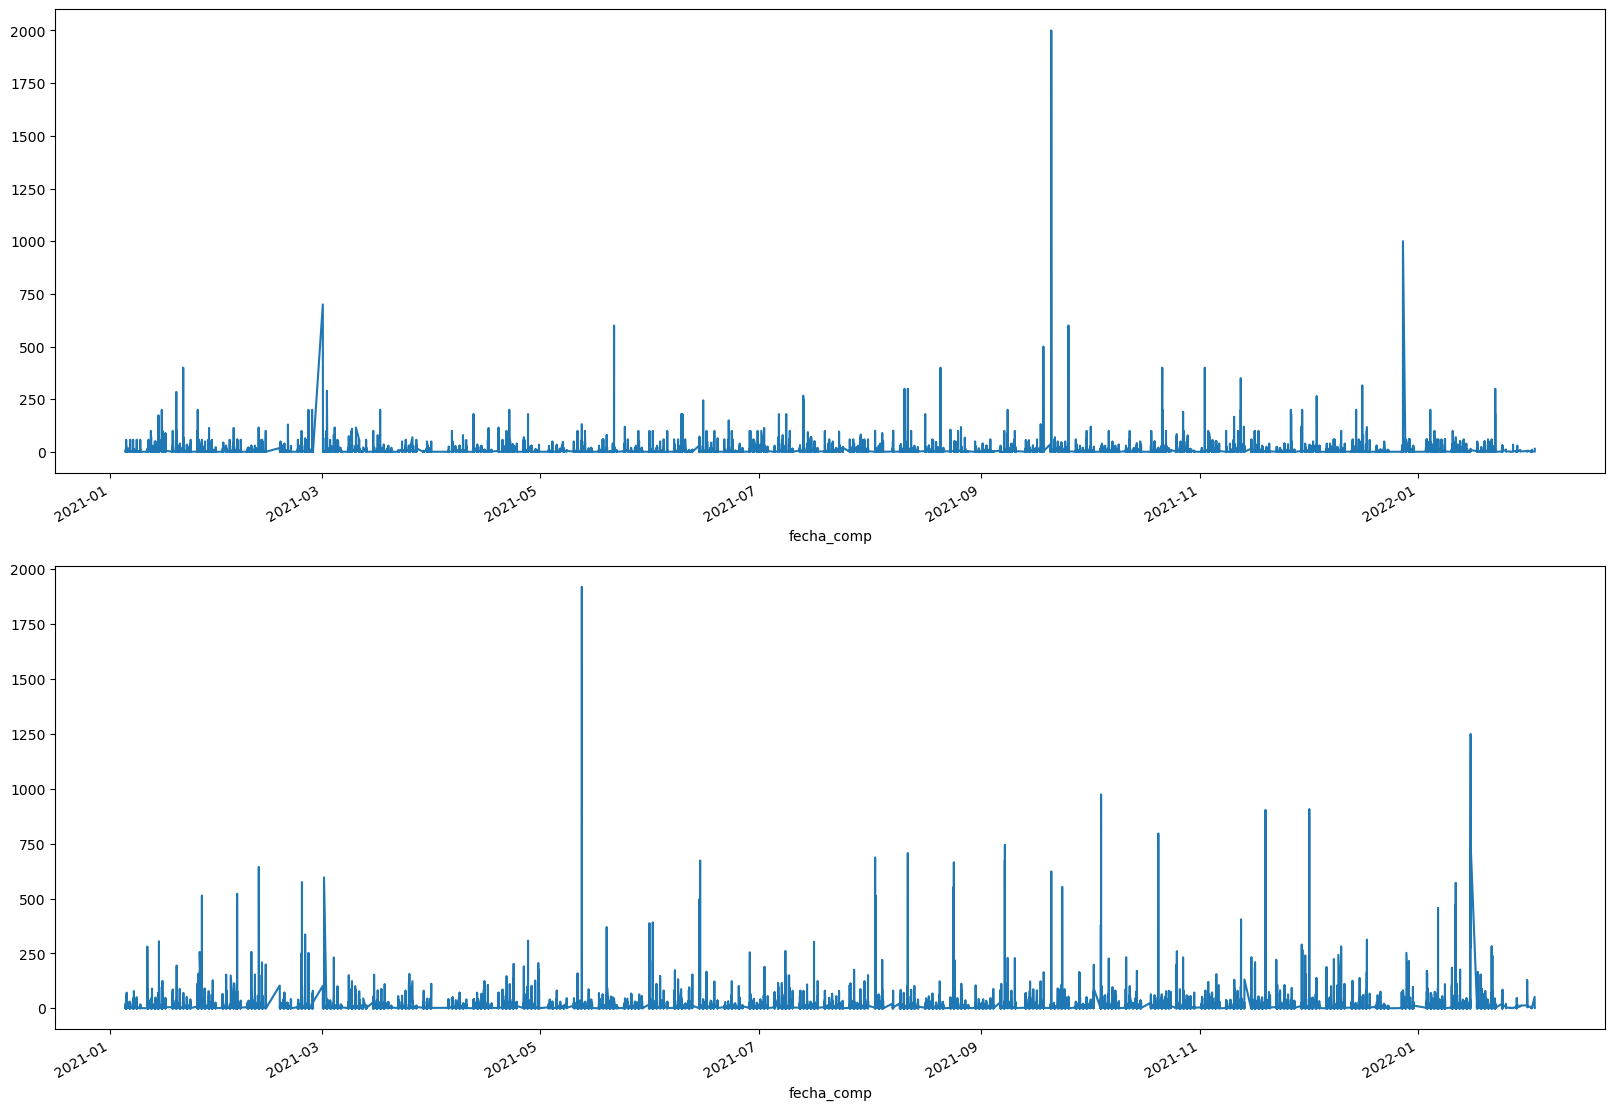

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1, dpi=100, figsize=(20,15))

df_ventas_fecha.cantidad.plot(ax=ax1)
df_ventas_fecha.monto_dolar.plot(ax=ax2)

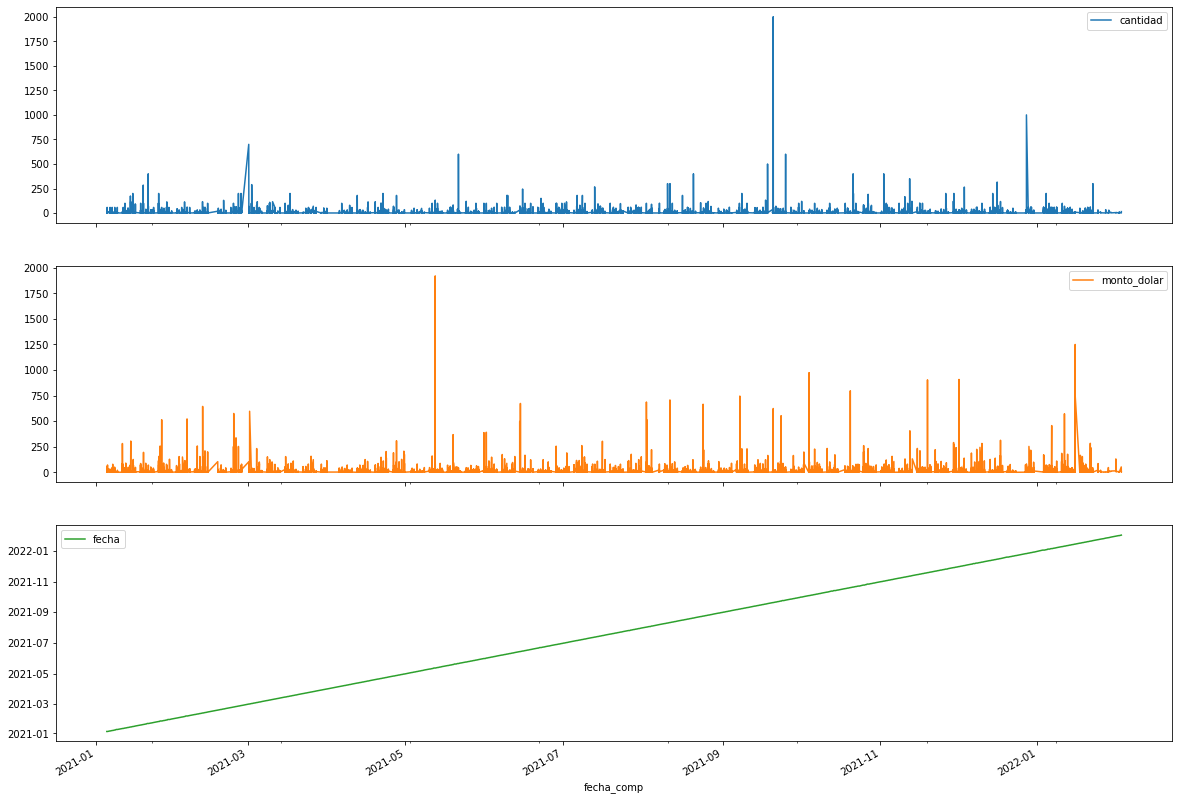

In [20]:
gr = df_ventas_fecha.plot(figsize=(20,15), subplots=True)

In [141]:
df_ventas_mes = df_ventas_fecha
df_ventas_mes['mes_anio'] = df_ventas_mes.fecha.dt.strftime('%m-%Y')
df_ventas_mes['dia_semana'] = df_ventas_mes.fecha.dt.weekday
df_ventas_mes.query('monto_dolar > 2985')


fecha  cantidad  monto_dolar  num mes_anio  dia_semana
303 2022-01-11     700.6  2985.851546   60  01-2022           1

<AxesSubplot:xlabel='fecha_comp'>

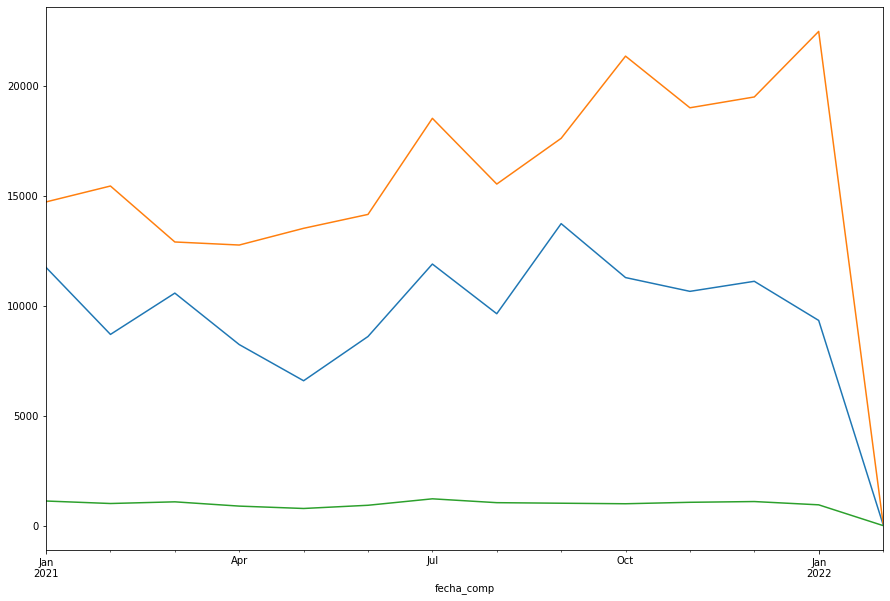

In [22]:
df_ventas_mes.cantidad.resample('M').sum().plot(figsize=(15,10))
df_ventas_mes.monto_dolar.resample('M').sum().plot(figsize=(15,10))
df_ventas_mes.num.resample('M').nunique().plot(figsize=(15,10))

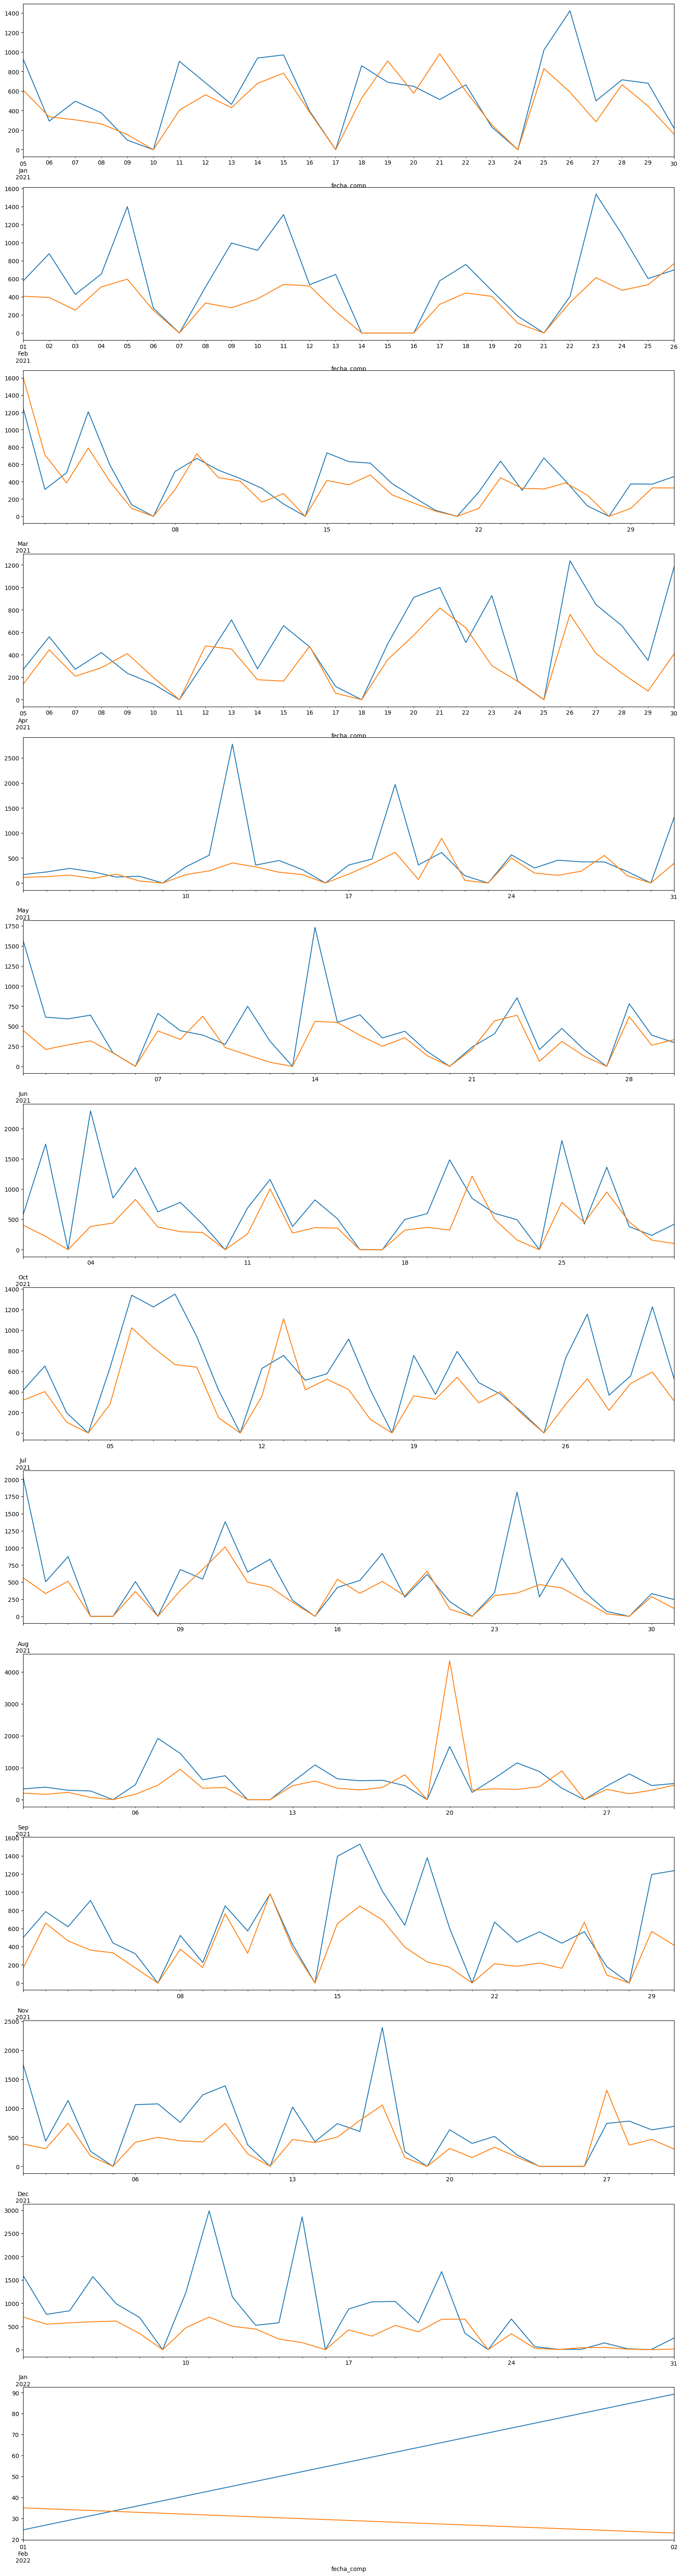

In [23]:
n_graf = len(df_ventas_mes.mes_anio.unique())

fig, ax = plt.subplots(n_graf, 1, dpi=100, figsize=(20,80))

i=0

for mes_anio in df_ventas_mes.mes_anio.unique():
    df_graf= df_ventas_mes[df_ventas_mes.mes_anio == mes_anio]
    df_graf.monto_dolar.resample('D').sum().plot(ax=ax[i])
    df_graf.cantidad.resample('D').sum().plot(ax=ax[i])
    i=i+1

/home/diana/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1200: UserWarning: Attempting to set identical left == right == 2719.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)
/home/diana/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1200: UserWarning: Attempting to set identical left == right == 2719.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


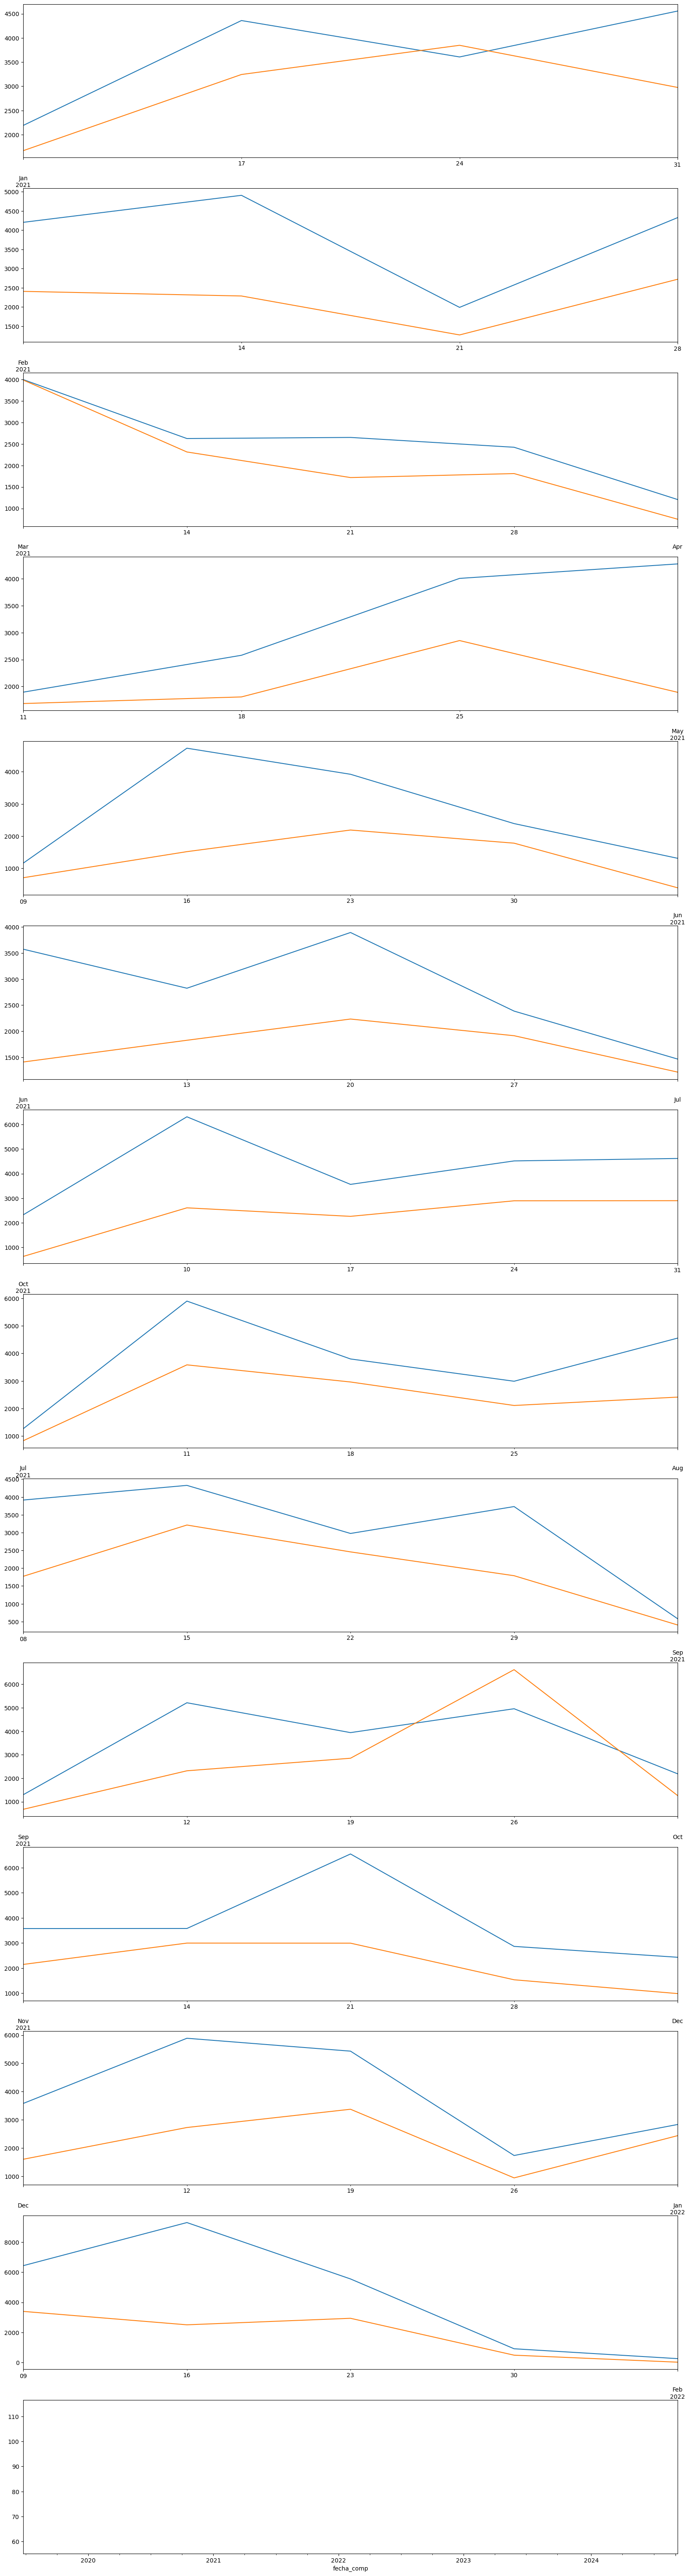

In [24]:
n_graf = len(df_ventas_mes.mes_anio.unique())

fig, ax = plt.subplots(n_graf, 1, dpi=100, figsize=(20,80))

i=0
for mes_anio in df_ventas_mes.mes_anio.unique():
    df_graf= df_ventas_mes[df_ventas_mes.mes_anio == mes_anio]
    df_graf.monto_dolar.resample('W').sum().plot(ax=ax[i])
    df_graf.cantidad.resample('W').sum().plot(ax=ax[i])
    i=i+1

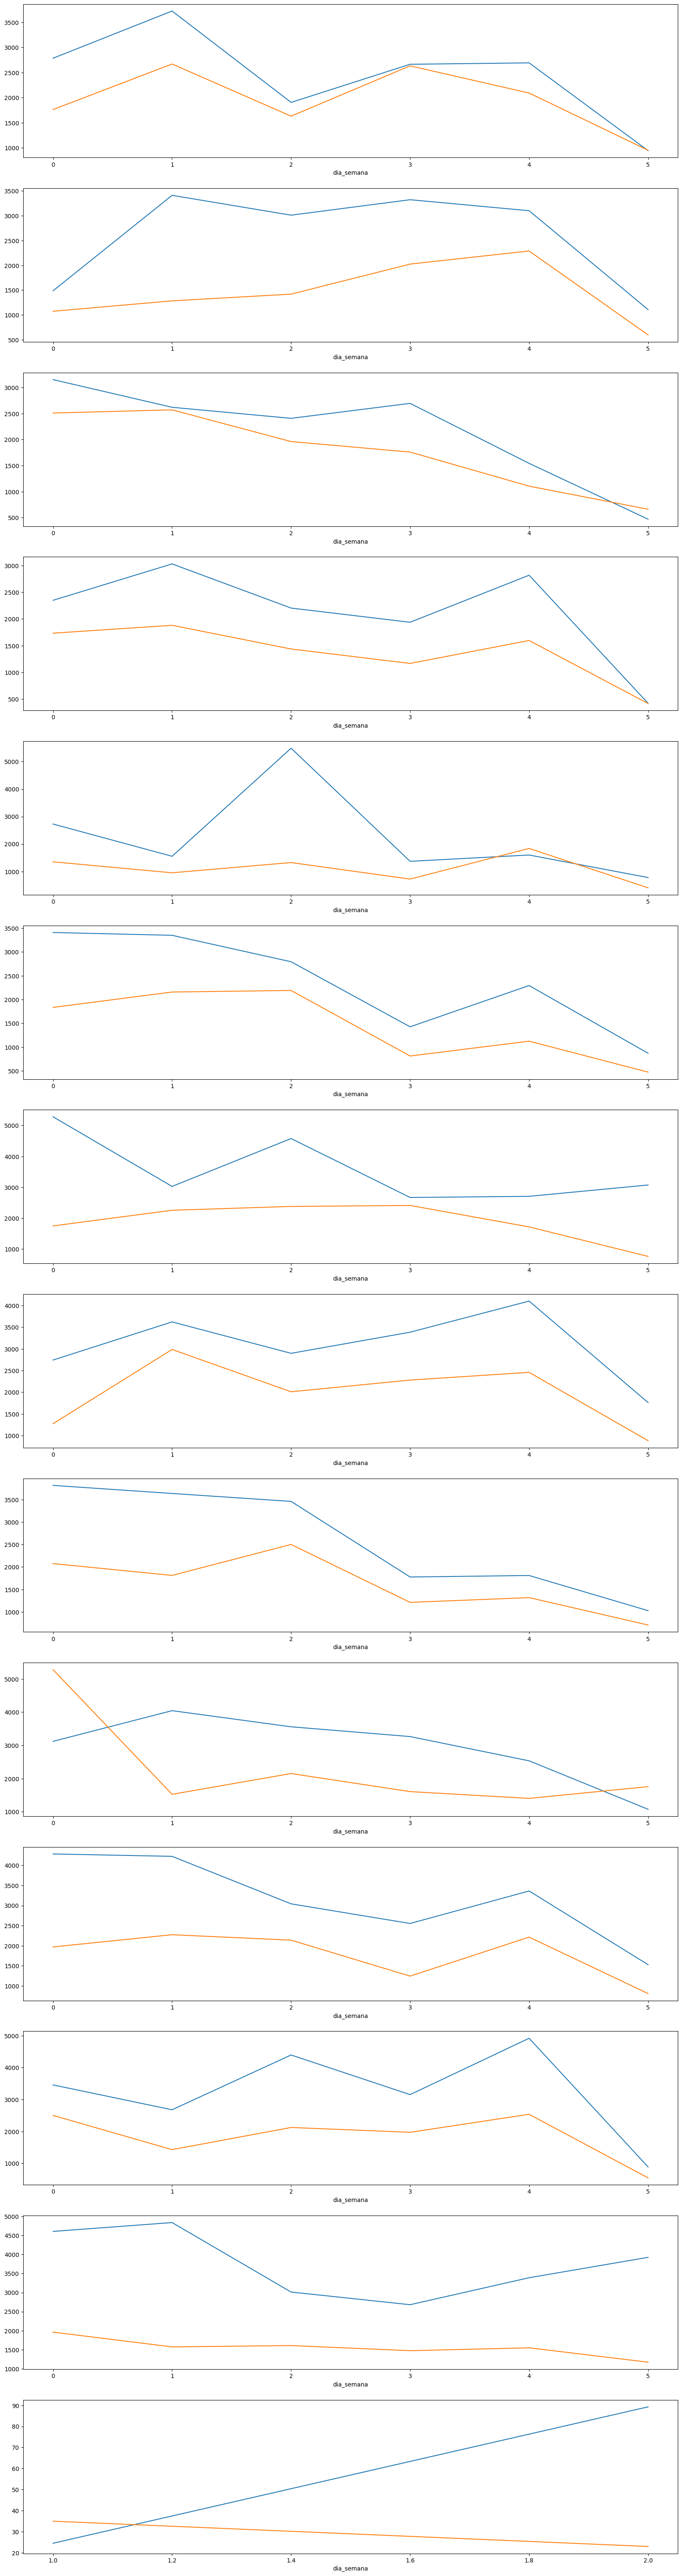

In [25]:
n_graf = len(df_ventas_mes.mes_anio.unique())

fig, ax = plt.subplots(n_graf, 1, dpi=100, figsize=(20,80))

i=0
for mes_anio in df_ventas_mes.mes_anio.unique():
    df_graf= df_ventas_mes[df_ventas_mes.mes_anio == mes_anio]
    df_graf.groupby('dia_semana').monto_dolar.sum().plot(ax=ax[i])
    df_graf.groupby('dia_semana').cantidad.sum().plot(ax=ax[i])
    i=i+1

Los lunes y martes son los días en los que más se vende en $. El viernes en Volumen

Los jueves son los días que menos se vende, que sea en volumen o en $

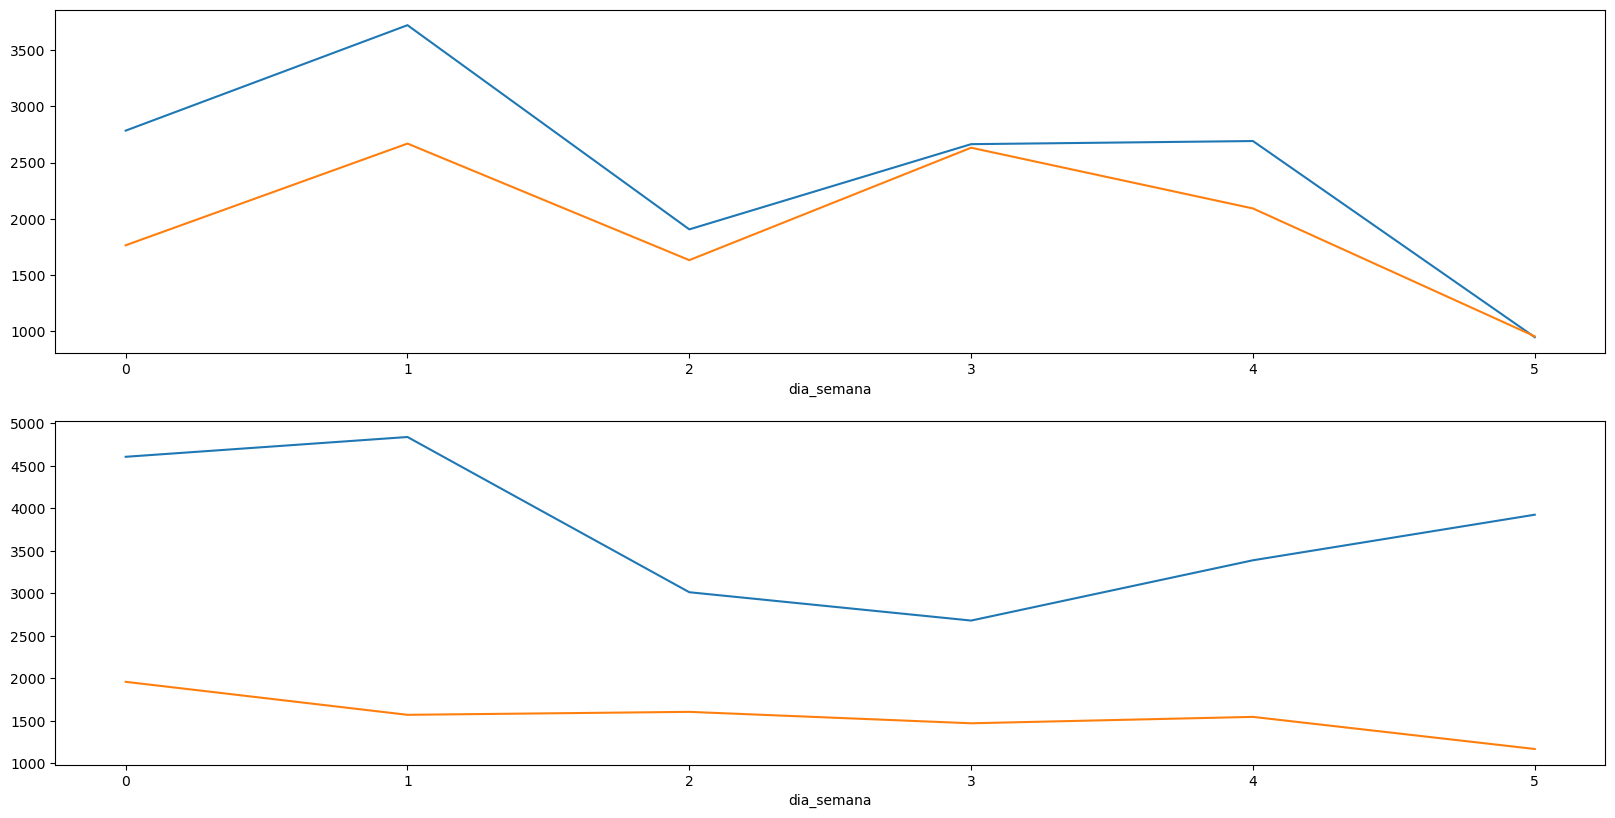

In [26]:

fig, ax = plt.subplots(2, 1, dpi=100, figsize=(20,10))

i=0
for mes_anio in ['01-2021', '01-2022']:
    df_graf= df_ventas_mes[df_ventas_mes.mes_anio == mes_anio]
    df_graf.groupby('dia_semana').monto_dolar.sum().plot(ax=ax[i])
    df_graf.groupby('dia_semana').cantidad.sum().plot(ax=ax[i])
    i=i+1

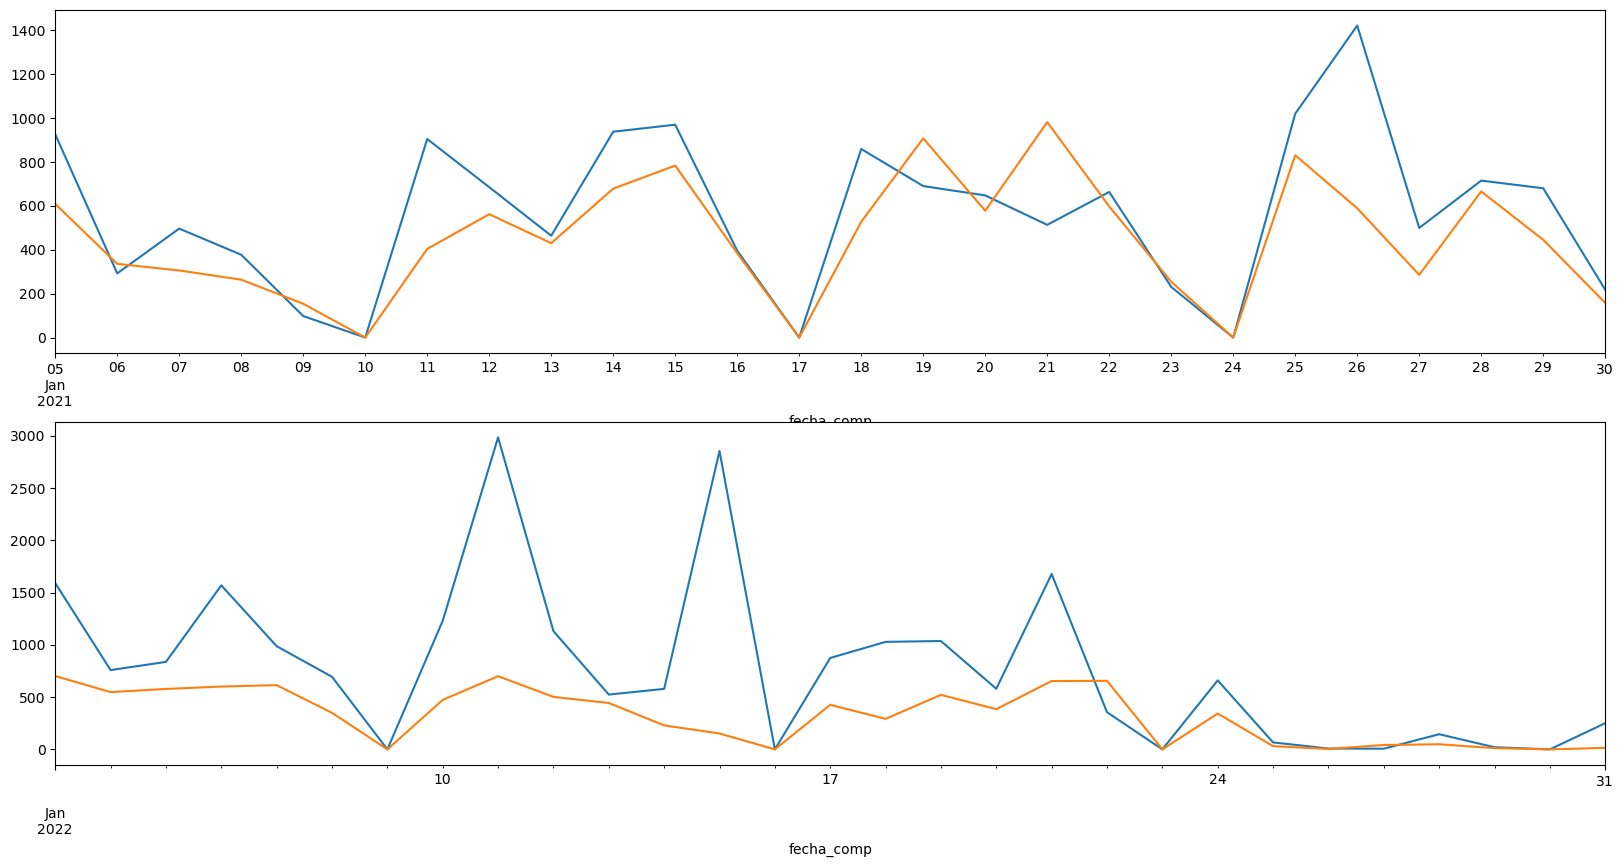

In [27]:
fig, ax = plt.subplots(2, 1, dpi=100, figsize=(20,10))

i=0
for mes_anio in ['01-2021', '01-2022']:
    df_graf= df_ventas_mes[df_ventas_mes.mes_anio == mes_anio]
    df_graf.monto_dolar.resample('D').sum().plot(ax=ax[i])
    df_graf.cantidad.resample('D').sum().plot(ax=ax[i])
    i=i+1

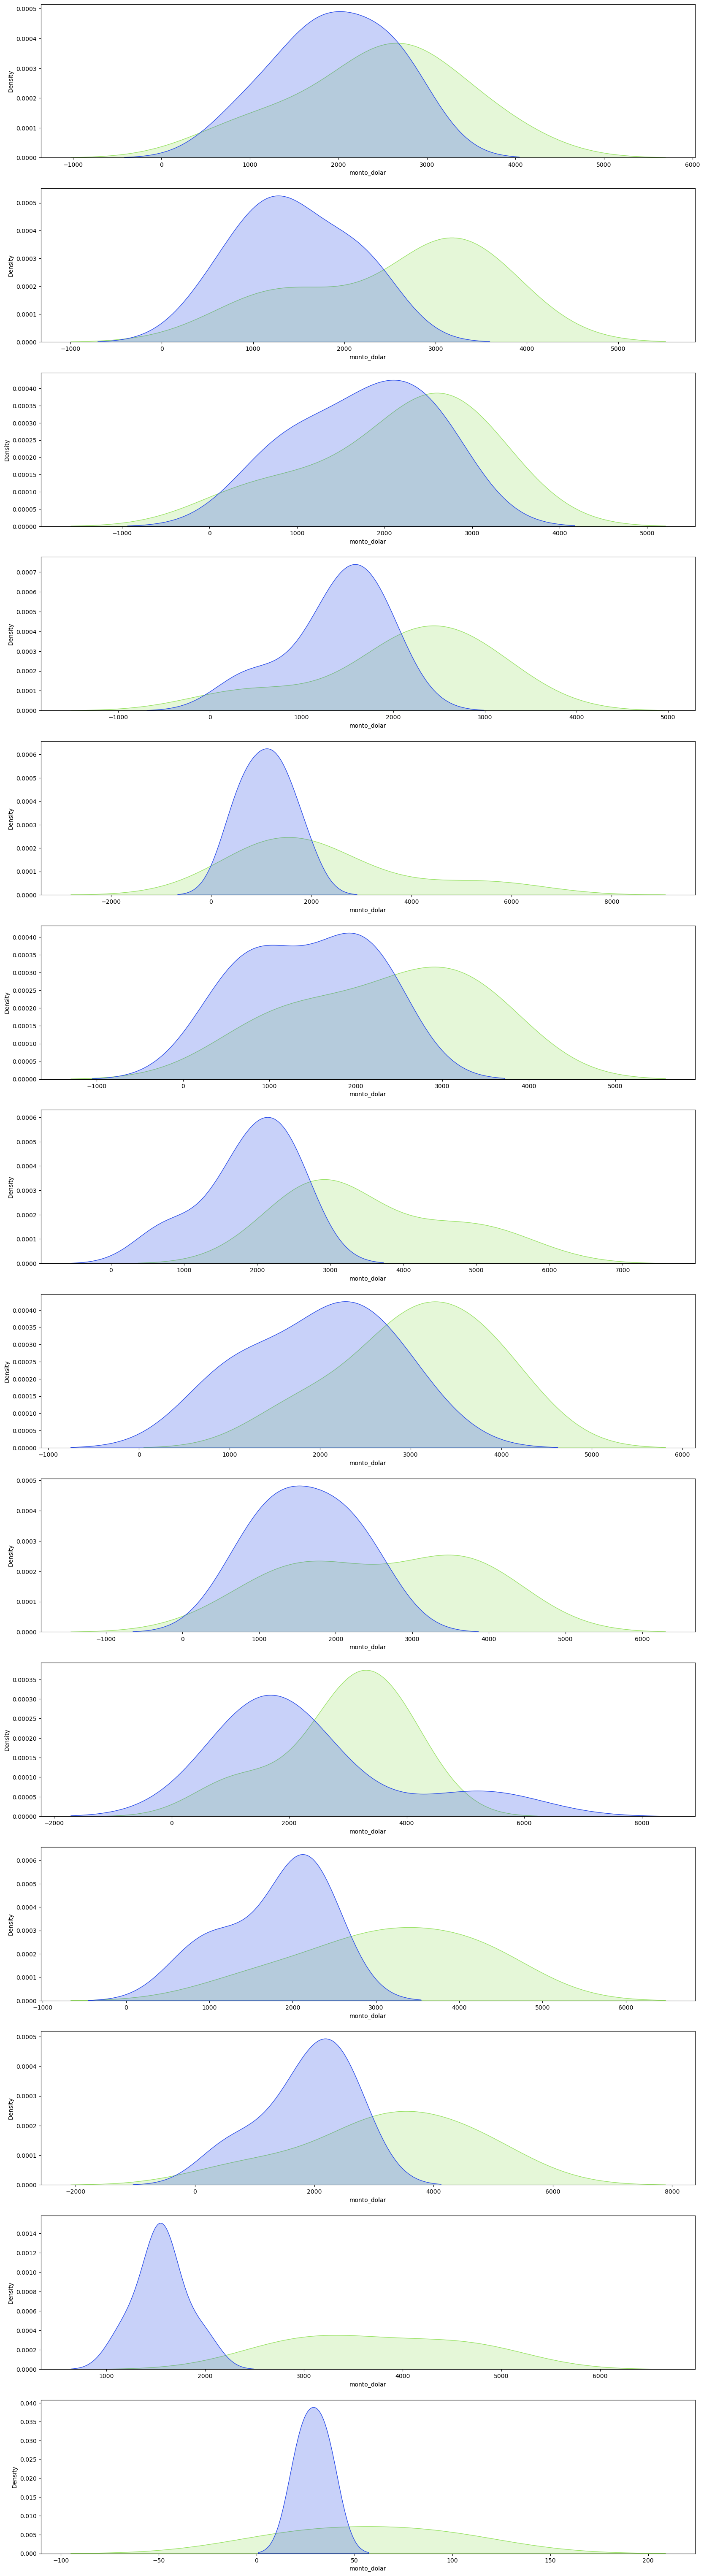

In [28]:
n_graf = len(df_ventas_mes.mes_anio.unique())

fig, ax = plt.subplots(n_graf, 1, dpi=100, figsize=(20,80))

i=0

for mes_anio in df_ventas_mes.mes_anio.unique():
    df_graf= df_ventas_mes[df_ventas_mes.mes_anio == mes_anio]
    sns.kdeplot(df_graf.groupby('dia_semana').monto_dolar.sum(),color=VERDE,shade=True, ax=ax[i])
    sns.kdeplot(df_graf.groupby('dia_semana').cantidad.sum(),color=AZUL,shade=True, ax=ax[i])
    i=i+1

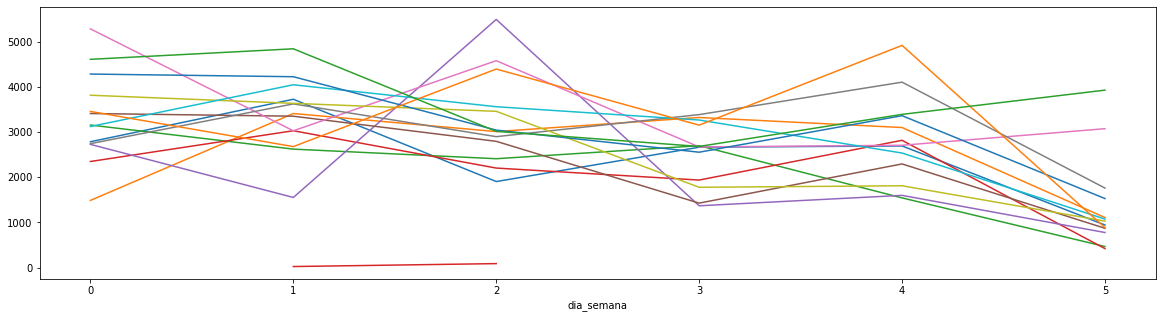

In [29]:
for mes_anio in df_ventas_mes.mes_anio.unique():
    df_graf= df_ventas_mes[df_ventas_mes.mes_anio == mes_anio]
    df_graf.groupby('dia_semana').monto_dolar.sum().plot(figsize=(20,5))

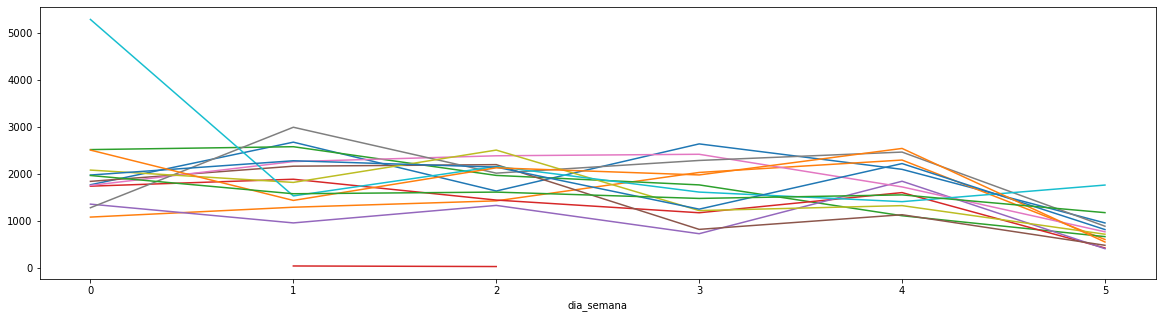

In [30]:
for mes_anio in df_ventas_mes.mes_anio.unique():
    df_graf= df_ventas_mes[df_ventas_mes.mes_anio == mes_anio]
    df_graf.groupby('dia_semana').cantidad.sum().plot(figsize=(20,5))

In [37]:
df_ventas_fecha = df_ventas.pivot_table(index='fecha', values=['num', 'cantidad', 'monto_dolar'], 
                                        aggfunc={'num':'nunique', 'cantidad':sum, 'monto_dolar':sum })
df_ventas_fecha

cantidad  monto_dolar  num
fecha                                 
2021-01-05    609.40   926.821704   49
2021-01-06    335.98   292.536671   48
2021-01-07    305.85   496.648389   48
2021-01-08    264.00   377.470866   42
2021-01-09    154.00    98.059123   17
...              ...          ...  ...
2022-01-28     49.00   145.189076    4
2022-01-29     12.00    20.564211    2
2022-01-31     15.00   250.711579    3
2022-02-01     35.00    24.529536    5
2022-02-02     23.00    89.265957    3

[323 rows x 3 columns]

In [32]:
df_ventas_fecha.describe()

cantidad  monto_dolar         num
count   323.000000   323.000000  323.000000
mean    408.934241   673.296069   41.346749
std     326.413309   471.914582   13.542567
min       4.000000     6.631027    1.000000
25%     224.375000   372.365339   33.000000
50%     364.000000   563.803922   42.000000
75%     516.440000   849.194177   51.000000
max    4350.000000  2985.851546   79.000000

<AxesSubplot:xlabel='fecha'>

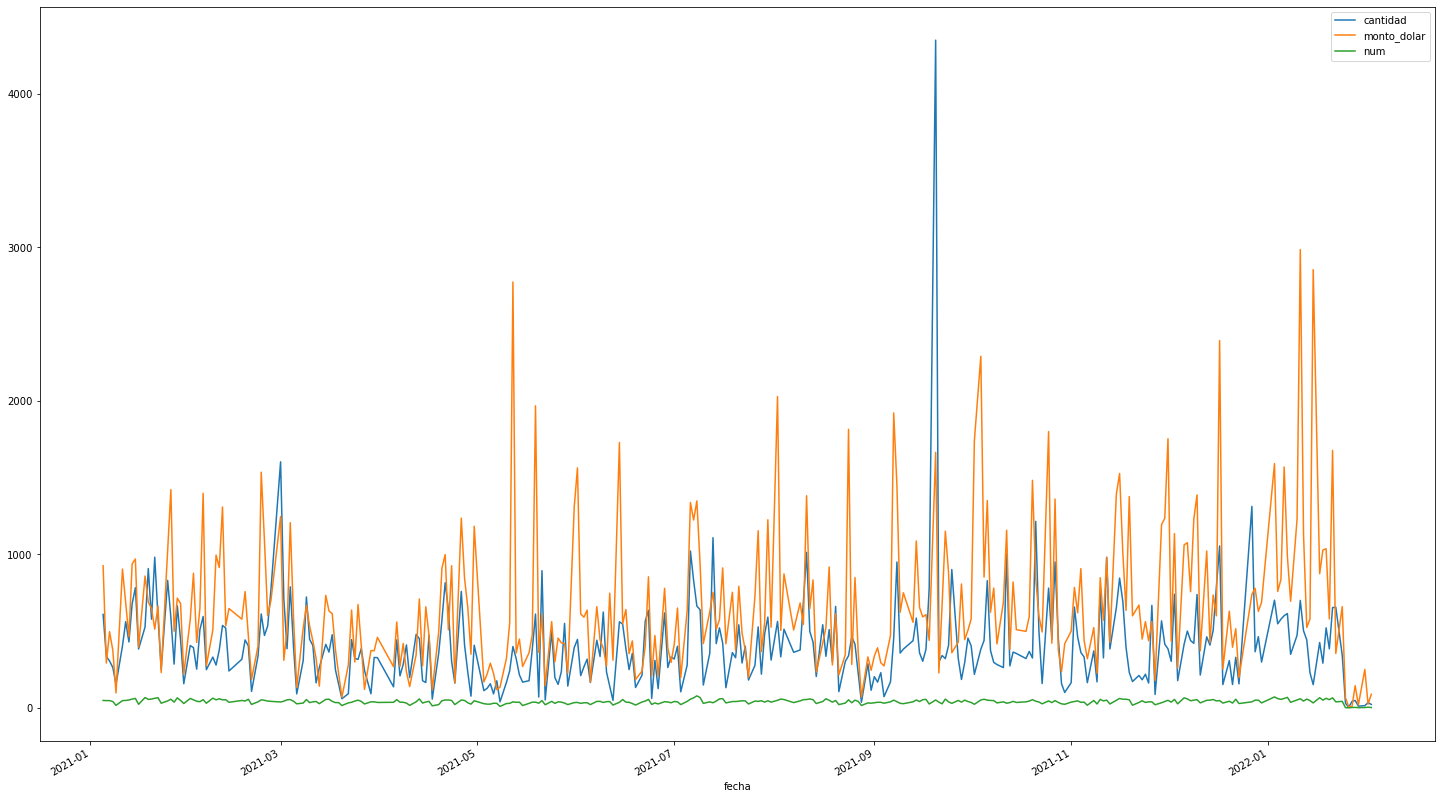

In [33]:
df_ventas_fecha.plot(figsize=(25, 15))

array([<AxesSubplot:xlabel='fecha'>, <AxesSubplot:xlabel='fecha'>,
       <AxesSubplot:xlabel='fecha'>], dtype=object)

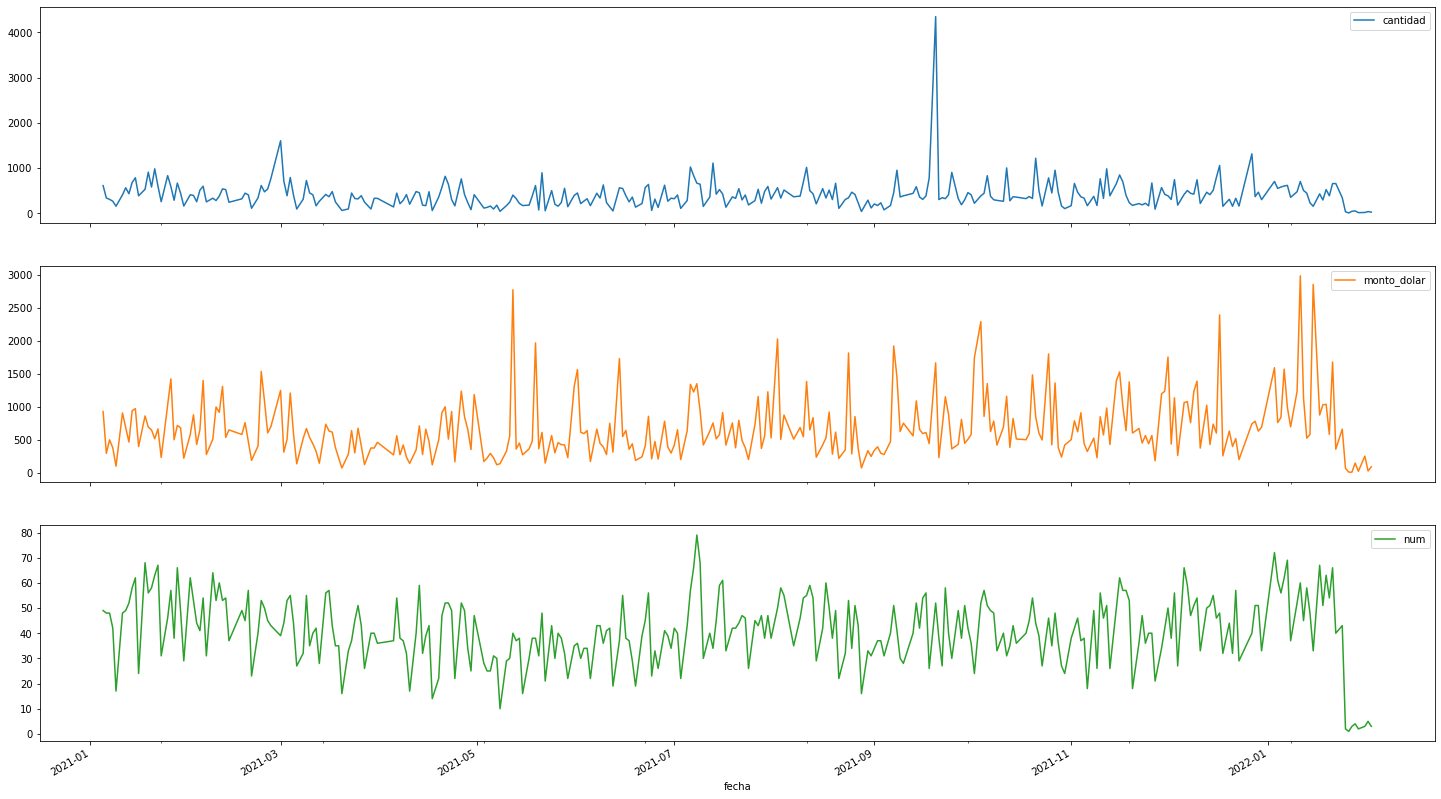

In [34]:
df_ventas_fecha.plot(figsize=(25, 15), subplots=True)

In [93]:
# Definición de los colores para los gráficos
TITULOS = '#17407b'
MONTO = '#99e265' #'#5ebc0d'
VOLUMEN = '#2649e8'  #'#17407b'
FACTURAS = '#fff952' #'#efea46'

# Definir colores específicos para cada métrica
# Ver aquí paletas de colores https://coolors.co/palettes/trending
COLORES = {'monto_dolar:Q': 'greens', 
           'cantidad:Q': 'blues', 
           'num:Q': 'oranges'}


In [ ]:
n_graf = len(df_ventas_mes.mes_anio.unique())

fig, ax = plt.subplots(n_graf, 1, dpi=100, figsize=(20,80))

i=0
for mes_anio in df_ventas_mes.mes_anio.unique():
    df_graf= df_ventas_mes[df_ventas_mes.mes_anio == mes_anio]
    df_graf.groupby('dia_semana').monto_dolar.sum().plot(ax=ax[i])
    df_graf.groupby('dia_semana').cantidad.sum().plot(ax=ax[i])
    i=i+1

In [76]:
alt.Chart(df_ventas_fecha).mark_bar(size=1).encode(
    x='fecha:T',
    y='monto_dolar:Q',
    color=alt.Color(
        'month(fecha):O'),
    tooltip=[
        alt.Tooltip('fecha:T', title='Fecha'),
        alt.Tooltip('monto_dolar:Q', title='Ventas en $')
    ]).properties(width=800, height=200)

alt.Chart(...)

In [136]:
x = alt.X('day(fecha):O', title='Fecha', axis = alt.Axis(labelAngle=90, labelFontSize=8))
y1 = alt.Y('monto_dolar:Q', title = '')
y2 = alt.Y('cantidad:Q', title = '')
y3 = alt.Y('num:Q', title = '')


for x in ['yearmonth(fecha):T']

base = alt.Chart(df_ventas_fecha).encode(x=x)

monto = base.mark_bar(color=MONTO).encode(y=y1,
                tooltip = [alt.Tooltip('fecha', title='Fecha'), 
                   alt.Tooltip('monto_dolar', title='Ventas en $')])

volumen = base.mark_bar(color=VOLUMEN).encode(y=y2,
                tooltip = [alt.Tooltip('fecha', title='Fecha'),  
                   alt.Tooltip('cantidad', title='Volumen de Ventas')])
                                             
facturas = base.mark_bar(color=FACTURAS,).encode(y=y3,
                tooltip = [alt.Tooltip('fecha', title='Fecha'), 
                   alt.Tooltip('num', title='N° de Facturas')])

SyntaxError: invalid syntax (655983366.py, line 7)

In [163]:
df_ventas_dia_semana = df_ventas_fecha.pivot_table(index=df_ventas_fecha.fecha.dt.strftime('%m-%Y'),
                                            columns=df_ventas_fecha.fecha.dt.weekday, aggfunc={'monto_dolar': sum},
                                            fill_value=0)
df_ventas_dia_semana 

monto_dolar                                                      \
fecha              0            1            2            3            4   
fecha                                                                      
01-2021  2784.790848  3724.941735  1904.395292  2664.156668  2691.912089   
01-2022  4607.765117  4840.628789  3014.172976  2680.853759  3390.207444   
02-2021  1487.808610  3409.444342  3009.591629  3321.042178  3099.457197   
02-2022     0.000000    24.529536    89.265957     0.000000     0.000000   
03-2021  3154.429796  2621.734764  2409.412415  2697.310711  1542.804509   
04-2021  2347.962698  3028.319106  2202.769910  1937.128764  2816.807784   
05-2021  2726.828498  1552.428012  5490.038652  1368.441352  1598.738326   
06-2021  3409.068815  3349.947459  2794.266252  1427.249511  2294.084378   
07-2021  2742.526508  3622.278674  2897.440111  3385.056171  4102.983283   
08-2021  3813.911816  3634.343572  3457.868795  1777.697439  1811.015563   
09-2021  3122.104340  4045.390292  3559.772908  3265.433007  2535.006467   
10-2021  5281.097548  3027.236408  4577.617768  2670.035010  2706.640421   
11-2021  4282.041414  4223.213901  3041.794665  2553.439244  3361.564040   
12-2021  3455.586364  2677.405213  4393.111531  3152.304079  4916.284466   

                      
fecha              5  
fecha                 
01-2021   943.314263  
01-2022  3926.310072  
02-2021  1108.215054  
02-2022     0.000000  
03-2021   467.503788  
04-2021   421.100324  
05-2021   777.268368  
06-2021   870.838121  
07-2021  1760.444940  
08-2021  1029.554831  
09-2021  1074.564331  
10-2021  3073.494269  
11-2021  1528.143621  
12-2021   886.941365

In [158]:
mapa = alt.Chart(df_ventas_fecha).mark_rect().encode(
                x=alt.X('day(fecha):T', title='Días de la Semana', axis = alt.Axis(labelAngle=0, labelFontSize=14)),
                y=alt.Y('yearmonth(fecha):T', title = 'Ventas en $', scale=alt.Scale(zero=False), 
                  axis = alt.Axis(grid=True, titleAnchor='middle', titleAngle = 270, labelFontSize=10)),
                color=alt.Color(
                    'sum(monto_dolar):Q', scale=alt.Scale(scheme='yellowgreenblue')),
                tooltip=[
                    alt.Tooltip('day(fecha):T', title='Día'),
                    alt.Tooltip('yearmonth(fecha):T', title='Mes y Año'),
                    alt.Tooltip('sum(monto_dolar):Q', title='Ventas en $')]
                ).properties(title='Ventas en $ por Día de la Semana',
                             width=300, 
                             height=300
                ).configure_title(
                    fontSize = 16,
                    anchor = 'middle',
                    color = TITULOS,
                ).interactive()

mapa

alt.Chart(...)

In [187]:
barras = alt.Chart(df_ventas_fecha).mark_bar().encode(
                x=alt.X('day(fecha):T', title='Días de la Semana', axis = alt.Axis(labelAngle=0, labelFontSize=14)),
                y=alt.Y('sum(monto_dolar):Q', title = 'Ventas en $', scale=alt.Scale(zero=False), 
                  axis = alt.Axis(grid=True, titleAnchor='middle', titleAngle = 270, labelFontSize=10)),
                color=alt.Color(
                    'sum(monto_dolar):Q', scale=alt.Scale(scheme='yellowgreenblue')),
                tooltip=[
                    alt.Tooltip('day(fecha):T', title='Día'),
                    alt.Tooltip('sum(monto_dolar):Q', title='Ventas en $')],
                ).properties(title='Ventas en $ por Día de la Semana',
                             width=600, 
                             height=300
                ).configure_title(
                    fontSize = 16,
                    anchor = 'middle',
                    color = TITULOS,
                ).interactive()
barras

alt.Chart(...)

In [178]:
df_ventas_dia_mes = df_ventas_fecha.pivot_table(index=df_ventas_fecha.fecha.dt.strftime('%m-%Y'),
                                            columns=df_ventas_fecha.fecha.dt.day, aggfunc={'monto_dolar': sum},
                                            fill_value=0)
df_ventas_dia_mes

monto_dolar                                                      \
fecha             1            2            3            4            5    
fecha                                                                      
01-2021     0.000000     0.000000     0.000000     0.000000   926.821704   
01-2022     0.000000     0.000000  1591.593750   758.901031   837.132114   
02-2021   576.868495   877.654503   426.736569   651.904401  1398.064662   
02-2022    24.529536    89.265957     0.000000     0.000000     0.000000   
03-2021  1247.560550   310.635069   502.960760  1207.091429   590.472359   
04-2021     0.000000     0.000000     0.000000     0.000000   268.741041   
05-2021     0.000000     0.000000   169.544003   220.616036   291.866310   
06-2021  1563.823121   612.552178   591.345295   637.657822   168.589568   
07-2021   416.055473   650.871448   197.589427     0.000000   634.166975   
08-2021     0.000000  2028.349967   504.849055   873.107250     0.000000   
09-2021   338.374591   391.866812   294.479298   274.037580     0.000000   
10-2021   579.193280  1742.244297     0.000000  2291.216630   853.060533   
11-2021   500.472527   785.301339   619.440529   907.849890   440.254425   
12-2021  1754.004032   433.751553  1135.519833   259.908524     0.000000   

                                                                          ...  \
fecha             6            7            8            9            10  ...   
fecha                                                                     ...   
01-2021   292.536671   496.648389   377.470866    98.059123     0.000000  ...   
01-2022  1569.805274   987.729675   694.787286     0.000000  1230.453988  ...   
02-2021   274.759691     0.000000   507.689803   995.648242   914.567090  ...   
02-2022     0.000000     0.000000     0.000000     0.000000     0.000000  ...   
03-2021   134.006455     0.000000   518.569803   668.978256   532.901499  ...   
04-2021   559.966597   271.320995   419.808247   235.351498   139.390734  ...   
05-2021   224.324624   119.475605   135.584869     0.000000   324.692543  ...   
06-2021     0.000000   659.694432   443.874941   389.142882   273.577969  ...   
07-2021  1338.564721  1224.456318  1348.962770   937.139976   419.200390  ...   
08-2021     0.000000   508.017601     0.000000   683.950377   544.170909  ...   
09-2021   470.278577  1921.822259  1448.564735   623.570036   750.432271  ...   
10-2021  1351.338235   623.452785   780.975787   417.384236     0.000000  ...   
11-2021   320.924444     0.000000   523.150110   225.858388   848.488017  ...   
12-2021  1062.589958  1076.601677   757.338205  1231.157563  1387.858650  ...   

                                                                         \
fecha            22           23           24           25           26   
fecha                                                                     
01-2021  663.691129   230.979657     0.000000  1020.231259  1422.078627   
01-2022  355.457557     0.000000   660.230290    66.785863     7.997908   
02-2021  403.250313  1536.141598  1089.783277   601.951645   698.116953   
02-2022    0.000000     0.000000     0.000000     0.000000     0.000000   
03-2021  280.979318   637.937824   299.366883   673.760794   407.773434   
04-2021  508.427792   926.682998   164.130460     0.000000  1236.686858   
05-2021  145.019230     0.000000   562.645354   299.939176   455.189314   
06-2021  405.628004   854.401915   208.702323   471.923384   205.354236   
07-2021  488.747125   376.931406   199.702662     0.000000   727.887505   
08-2021    0.000000   347.174693  1815.168917   283.621166   849.900336   
09-2021  673.555403  1151.237664   881.810325   359.972220     0.000000   
10-2021  599.594966   495.002299     0.000000  1800.578341   421.847191   
11-2021  670.511066   448.669405   562.609218   438.017893   563.803922   
12-2021  516.195699   198.163441     0.000000     0.000000     0.000000   

                                                              

In [182]:
df_ventas_fecha['dia_mes'] = df_ventas_mes.fecha.dt.day
df_ventas_fecha

fecha  cantidad  monto_dolar  num mes_anio  dia_semana  dia_mes
0   2021-01-05    609.40   926.821704   49  01-2021           1        5
1   2021-01-06    335.98   292.536671   48  01-2021           2        6
2   2021-01-07    305.85   496.648389   48  01-2021           3        7
3   2021-01-08    264.00   377.470866   42  01-2021           4        8
4   2021-01-09    154.00    98.059123   17  01-2021           5        9
..         ...       ...          ...  ...      ...         ...      ...
318 2022-01-28     49.00   145.189076    4  01-2022           4       28
319 2022-01-29     12.00    20.564211    2  01-2022           5       29
320 2022-01-31     15.00   250.711579    3  01-2022           0       31
321 2022-02-01     35.00    24.529536    5  02-2022           1        1
322 2022-02-02     23.00    89.265957    3  02-2022           2        2

[323 rows x 7 columns]

In [190]:
mapa = alt.Chart(df_ventas_fecha).mark_rect().encode(
                x=alt.X('dia_mes:O', title='Días del mes', axis = alt.Axis(labelAngle=0, labelFontSize=14)),
                y=alt.Y('yearmonth(fecha):T', title = 'Ventas en $', scale=alt.Scale(zero=False), 
                  axis = alt.Axis(grid=True, titleAnchor='middle', titleAngle = 270, labelFontSize=10)),
                color=alt.Color(
                    'sum(monto_dolar):Q', scale=alt.Scale(scheme='yellowgreenblue')),
                tooltip=[
                    alt.Tooltip('dia_mes:O', title='Día'),
                    alt.Tooltip('yearmonth(fecha):T', title='Mes y Año'),
                    alt.Tooltip('sum(monto_dolar):Q', title='Ventas en $')]
                ).properties(title='Ventas en $ por Día de la Semana',
                             width=800, 
                             height=300
                ).configure_title(
                    fontSize = 16,
                    anchor = 'middle',
                    color = TITULOS,
                ).interactive()

mapa

alt.Chart(...)

In [189]:
barras = alt.Chart(df_ventas_fecha).mark_bar().encode(
                x=alt.X('dia_mes:O', title='Días de la Semana', axis = alt.Axis(labelAngle=0, labelFontSize=14)),
                y=alt.Y('sum(monto_dolar):Q', title = 'Ventas en $', scale=alt.Scale(zero=False), 
                  axis = alt.Axis(grid=True, titleAnchor='middle', titleAngle = 270, labelFontSize=10)),
                color=alt.Color(
                    'sum(monto_dolar):Q', scale=alt.Scale(scheme='yellowgreenblue')),
                tooltip=[
                    alt.Tooltip('dia_mes:O', title='Día'),
                    alt.Tooltip('sum(monto_dolar):Q', title='Ventas en $')],
                ).properties(title='Ventas en $ por Día de la Semana',
                             width=800, 
                             height=300
                ).configure_title(
                    fontSize = 16,
                    anchor = 'middle',
                    color = TITULOS,
                ).interactive()
barras

alt.Chart(...)

In [38]:
df_ventas_fecha.reset_index(inplace=True)
df_ventas_fecha

fecha  cantidad  monto_dolar  num
0   2021-01-05    609.40   926.821704   49
1   2021-01-06    335.98   292.536671   48
2   2021-01-07    305.85   496.648389   48
3   2021-01-08    264.00   377.470866   42
4   2021-01-09    154.00    98.059123   17
..         ...       ...          ...  ...
318 2022-01-28     49.00   145.189076    4
319 2022-01-29     12.00    20.564211    2
320 2022-01-31     15.00   250.711579    3
321 2022-02-01     35.00    24.529536    5
322 2022-02-02     23.00    89.265957    3

[323 rows x 4 columns]

In [39]:
# Definición de los colores para los gráficos
TITULOS = '#17407b'
MONTO = '#99e265' #'#5ebc0d'
VOLUMEN = '#2649e8'  #'#17407b'
FACTURAS = '#fff952' #'#efea46'

#alt.data_transformers.disable_max_rows()

# Ejes 
x = alt.X('day(fecha):O', title='Fecha', axis = alt.Axis(labelAngle=90, labelFontSize=8))
y1 = alt.Y('monto_dolar:Q', title = '')
y2 = alt.Y('cantidad:Q', title = '')
y3 = alt.Y('num:Q', title = '')


base = alt.Chart(df_ventas_fecha).encode(x=x)

monto = base.mark_bar(color=MONTO).encode(y=y1,
                tooltip = [alt.Tooltip('fecha', title='Fecha'), 
                   alt.Tooltip('monto_dolar', title='Ventas en $')])

volumen = base.mark_bar(color=VOLUMEN).encode(y=y2,
                tooltip = [alt.Tooltip('fecha', title='Fecha'),  
                   alt.Tooltip('cantidad', title='Volumen de Ventas')])
                                             
facturas = base.mark_bar(color=FACTURAS,).encode(y=y3,
                tooltip = [alt.Tooltip('fecha', title='Fecha'), 
                   alt.Tooltip('num', title='N° de Facturas')])


grafico = alt.layer(monto, volumen)

grafico.properties(
        title='Ventas en $ - Volúmenes de Ventas - N° de Facturas',
        width=800
).configure_title(
    fontSize = 16,
    anchor = 'middle',
    color = TITULOS,
).configure_view(
    strokeWidth=1
)

alt.LayerChart(...)

In [ ]:
df_ventas_mes_anio.reset_index(inplace=True)

In [ ]:
# Definición de los colores para los gráficos
TITULOS = '#17407b'
MONTO = '#99e265' #'#5ebc0d'
VOLUMEN = '#2649e8'  #'#17407b'
FACTURAS = '#fff952' #'#efea46'

# Ejes 
x = alt.X('mes_anio:O', title='Mes y Año', axis = alt.Axis(labelAngle=90, labelFontSize=12))
y1 = alt.Y('monto_dolar:Q', title = '')
y2 = alt.Y('cantidad:Q', title = '')
y3 = alt.Y('num:Q', title = '')


base = alt.Chart(df_ventas_mes_anio).encode(x=x)

monto = base.mark_bar(color=MONTO, cornerRadiusTopLeft=3, cornerRadiusTopRight=3).encode(y=y1,
                tooltip = [alt.Tooltip('mes_anio', title='Mes y año'), 
                   alt.Tooltip('monto_dolar', title='Ventas en $')])

volumen = base.mark_bar(color=VOLUMEN).encode(y=y2,
                tooltip = [alt.Tooltip('mes_anio', title='Mes y año'),  
                   alt.Tooltip('cantidad', title='Volumen de Ventas')])
                                             
facturas = base.mark_bar(color=FACTURAS,).encode(y=y3,
                tooltip = [alt.Tooltip('mes_anio', title='Mes y año'), 
                   alt.Tooltip('num', title='N° de Facturas')])

textos1 = base.mark_text().encode(
    text = alt.Text(y1, format=',.5s', title = 'Ventas en $'),
)

grafico = alt.layer(monto, volumen, facturas)

grafico.properties(
        title='Ventas en $ - Volúmenes de Ventas - N° de Facturas',
        width=800
).configure_title(
    fontSize = 16,
    anchor = 'middle',
    color = TITULOS,
).configure_view(
    strokeWidth=1
)

In [ ]:
# Se trata de un gráfico de capas
# https://altair-viz.github.io/user_guide/compound_charts.html

# Definimos la selección para hacer el gráfico interactivo
# Cuando el mouse se acerca a la línea de un país, 
# esta aumenta de grosor
highlight = alt.selection(type='single', on='mouseover',
                          fields=['country'], nearest=True)


base = alt.Chart(df_ventas_fecha).mark_line().encode(
    x = alt.X('year:O', title='', axis = alt.Axis(labelAngle=0, labelFontSize=12)),
    y = alt.Y('life_expect:Q', title = 'Esperanza de vida', scale=alt.Scale(zero=False), 
              axis = alt.Axis(grid=True, titleAnchor='middle', titleAngle = 270, labelFontSize=10)),
    color = alt.Color('country:N', scale=alt.Scale(domain=paises, range=colores)), 
    tooltip = [alt.Tooltip('country', title='País'), 
               alt.Tooltip('life_expect', title='Esperanza de vida'), 
               alt.Tooltip('year', title='Año')]
)


# opacity=alt.value(0.5) permite que se muestren los puntos 
# opacity=alt.value(0) muestra líneas contínuas 
points = base.mark_circle().encode(
    opacity=alt.value(0.5)
).add_selection(
    highlight
).properties(
    title = f"Esperanza de vida en {mis_paises} de 1955 a 2005",
    width=600
)

# Permite cambiar el aspecto de las líneas cuando el ratón se acerca
# Se utiliza la negación de la selección ~highlight para evitar
# que el gráfico tenga las líneas resaltadas al cargar
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(1), alt.value(3))
)

# Para los gráficos multicapas, pueden utilizarse
# cualquiera de las 2 sintaxis (+ y alt.layer)

#points + lines

grafico = alt.layer(
  points,
  lines
).interactive()

grafico



heatmap = alt.Chart(source).mark_rect().encode(
    alt.X('IMDB_Rating:Q', bin=True),
    alt.Y('Rotten_Tomatoes_Rating:Q', bin=True),
    alt.Color('count()', scale=alt.Scale(scheme='greenblue'))
)

points = alt.Chart(source).mark_circle(
    color='black',
    size=5,
).encode(
    x='IMDB_Rating:Q',
    y='Rotten_Tomatoes_Rating:Q',
)

heatmap + points


base = alt.Chart(source).encode(x='year:O')

bar = base.mark_bar().encode(y='wheat:Q')

line =  base.mark_line(color='red').encode(
    y='wages:Q'
)

(bar + line).properties(width=600)

In [ ]:
df_ventas_fecha['Dia'] = df_ventas_fecha.fecha.dt.weekday
df_ventas_fecha['Mes'] = df_ventas_fecha.fecha.dt.month
df_ventas_fecha['Año'] = df_ventas_fecha.fecha.dt.year
df_ventas_fecha

In [ ]:
df_ventas_semana = df_ventas.pivot_table()

In [ ]:
%%time 
df_stock = pd.read_parquet(f"{BASE_DIR / 'datos/out/stock.parquet'}", engine='fastparquet')
df_stock